# EDA NR

## Librerías

In [18]:
import pandas as pd
import os
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import canny
from collections import defaultdict
from skimage.color import rgba2rgb, rgb2gray
from skimage.feature import local_binary_pattern
from itertools import combinations
from shapely.geometry import box, Polygon
from skimage.measure import shannon_entropy
import cv2
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.family'] = 'Times New Roman'




# Creación del dataset
#### Unión de dos archivos de layouts, uno con latitud y longitu y otro con el resto de la info

In [2]:
df1 = pd.read_csv('layoutsWithTags.csv')
df2 = pd.read_csv('layout_mas.csv', encoding='latin1')

layouts_todo = pd.merge(df1, df2, on='layout_id')
print(layouts_todo.head())


   trial_id  layout_id country_x relevant (new) tags  coincidencia  \
0    9446.0      53750    Brazil           2,4,5,6,8          True   
1    9479.0      53772    Brazil          2,4,5,6,11          True   
2    9692.0      53808       USA                 NaN          True   
3    9692.0      53808       USA            1,3,4,10          True   
4    9672.0      53817       USA                 NaN          True   

              field_name              location country_y  latitude  longitude  \
0              LRV_Milho  State of Mato Grosso    Brasil   -12.680    -56.921   
1   Sertanopolis - Milho       State of Paraná    Brasil   -23.058    -51.039   
2                 CF2225                  Iowa       USA    41.878    -93.097   
3                 CF2225                  Iowa       USA    41.878    -93.097   
4  CF2223_B1_10ft_Normal                  Iowa       USA    41.878    -93.097   

       flight_date  
0  2/24/2022 15:32  
1   4/7/2022 16:11  
2  6/28/2022 13:55  
3  6/28/

## Unión dataset Layouts con dataset de fotos

In [3]:

directorio = './clean_images'

filas = []

imagenes_en_directorio = [filename for filename in os.listdir(directorio)]

for filename in imagenes_en_directorio:
    layout_id = int(filename.split('_')[0])
    layout_info = layouts_todo[layouts_todo['layout_id'] == layout_id].iloc[0]
    country = layout_info['country_x']
    relevant = layout_info['relevant (new) tags']
    coincidencia = layout_info['coincidencia']
    field_name = layout_info['field_name']
    location = layout_info['location']
    latitude = layout_info['latitude']
    longitude = layout_info['longitude']
    flight_date = layout_info['flight_date']
    img = Image.open(os.path.join(directorio, filename))
    ancho, alto = img.size
    brillo = img.getextrema()[0][0]
    s, _, _ = img.convert('HSV').split()
    estadisticas_saturacion = ImageStat.Stat(s)
    saturacion = estadisticas_saturacion.mean[0]
    filas.append({
        'trial_id': layout_info['trial_id'],
        'layout_id': layout_id,
        'country': country,
        'relevant (new) tags': relevant,
        'coincidencia': coincidencia,
        'nombre_imagen': filename,
        'ancho': ancho,
        'alto': alto,
        'brillo': brillo,
        'tonalidad': 0,  
        'saturacion': saturacion,
        'field_name': field_name,
        'location': location,
        'latitude': latitude,
        'longitude': longitude,
        'flight_date': flight_date
    })

nuevo_df2 = pd.DataFrame(filas)



In [4]:
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()

## Separación de Tags

In [5]:
tag_mapping = {
    '1': 'dark_soil',
    '2': 'red_soil',
    '3': 'high_plant_density',
    '4': 'shadow',
    '5': 'stubble',
    '6': 'weed',
    '7': 'blurry',
    '8': 'dark_image',
    '9': 'bright_image',
    '10': 'grown_plants',
    '11': 'double_plants'
}

all_tags = ','.join(nuevo_df2['relevant (new) tags'].fillna('')).split(',')
unique_tags = set(all_tags)
unique_tags = {int(tag) for tag in unique_tags if tag.isdigit()}

for tag in unique_tags:
    column_name = tag_mapping[str(tag)]
    nuevo_df2[column_name] = nuevo_df2['relevant (new) tags'].apply(lambda x: 1 if str(tag) in str(x) else 0)

print(nuevo_df2.head())

   trial_id  layout_id    country relevant (new) tags  coincidencia  \
0    5882.0      31255  Argentina              4,6,11          True   
1    5882.0      31255  Argentina              4,6,11          True   
2    5882.0      31255  Argentina              4,6,11          True   
3    5882.0      31255  Argentina              4,6,11          True   
4    5882.0      31255  Argentina              4,6,11          True   

        nombre_imagen  ancho  alto  brillo  tonalidad  ...  red_soil  \
0  31255_12-3-1-5.png   2884    94       0          0  ...         0   
1  31255_12-3-1-7.png   2884    94       0          0  ...         0   
2  31255_12-5-1-4.png   2885    95       0          0  ...         0   
3  31255_14-3-1-1.png   2881    94       0          0  ...         0   
4  31255_15-4-1-8.png   2885    94       0          0  ...         0   

  high_plant_density shadow  stubble  weed blurry  dark_image  bright_image  \
0                  0      1        0     1      0           0

# Dimensiones de imagen

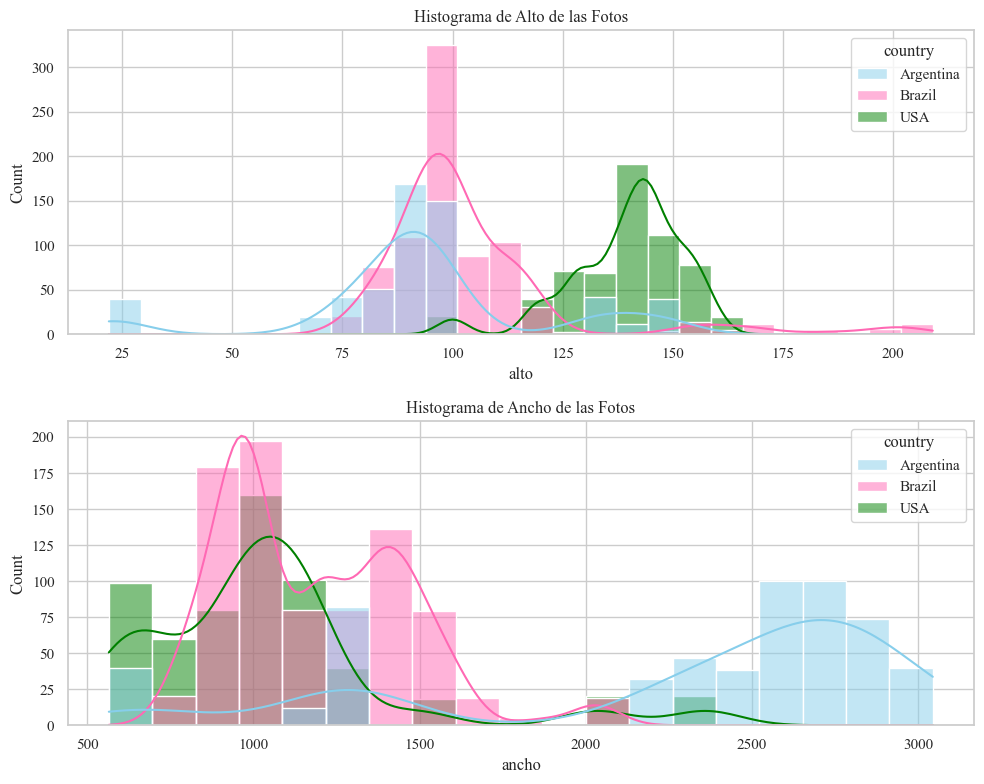

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo
sns.set(style="whitegrid")
colores = {'Brazil': '#FF69B4', 'USA': 'green', 'Argentina': '#87CEEB'}
plt.rcParams['font.family'] = 'Times New Roman'

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Histograma de alto de las fotos,  por país
sns.histplot(data=nuevo_df2, x='alto', hue='country', ax=axes[0], kde=True, palette= colores)
axes[0].set_title('Histograma de Alto de las Fotos')

# Histograma de Ancho de las fotos,  por país
sns.histplot(data=nuevo_df2, x='ancho', hue='country', ax=axes[1], kde=True, palette= colores)
axes[1].set_title('Histograma de Ancho de las Fotos')

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()

## Ratio ancho - largo

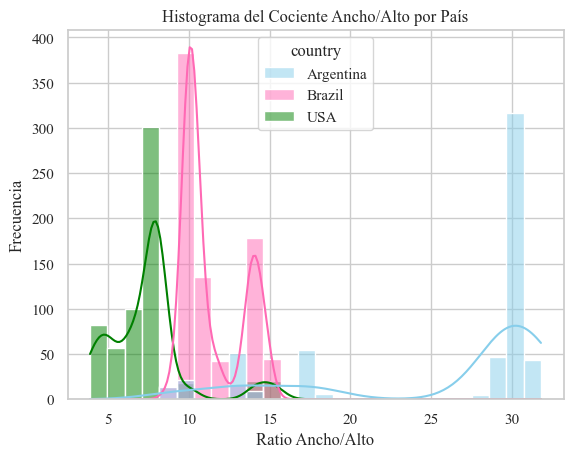

In [22]:
nuevo_df2['ratio_ancho_alto'] =  nuevo_df2['ancho']/ nuevo_df2['alto']

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'
# Histograma del ratio ancho/alto de las fotos, por país
sns.histplot(data=nuevo_df2, x='ratio_ancho_alto', hue='country', kde=True, palette=colores)
plt.title('Histograma del Cociente Ancho/Alto por País')
plt.xlabel('Ratio Ancho/Alto')
plt.ylabel('Frecuencia')

# Mostrar gráfico
plt.show()

# Descripción del dataset

In [8]:
print("El dataset está compuesto por",len(nuevo_df2),"imágenes")
print("Ancho - Mínimo:", nuevo_df2['ancho'].min())
print("Ancho - Máximo:", nuevo_df2['ancho'].max())
print("Alto - Mínimo:", nuevo_df2['alto'].min())
print("Alto - Máximo:", nuevo_df2['alto'].max())
print("Cantidad de ubicaciones:", len(nuevo_df2['location'].unique()))
ubicaciones_por_pais = nuevo_df2.groupby('country')['location'].unique()

for pais, ubicaciones in ubicaciones_por_pais.items():
    total_ubicaciones = len(ubicaciones)
    print(f"País: {pais}")
    print(f"Total de regiones: {total_ubicaciones}")
    print("Regiones:")
    for ubicacion in ubicaciones:
        print(f"- {ubicacion}")
    print()



El dataset está compuesto por 1978 imágenes
Ancho - Mínimo: 565
Ancho - Máximo: 3044
Alto - Mínimo: 22
Alto - Máximo: 209
Cantidad de ubicaciones: 42
País: Argentina
Total de regiones: 10
Regiones:
- ARBA
- Las Cejas
- Chacabuco, BA
- Pergamino
- Manuel Ocampo
- Carlos Casares, BA
- Corral de Bustos
- La Cruz
- Rio Cuarto
- Las Varillas

País: Brazil
Total de regiones: 26
Regiones:
- Pontão RS
- Tibagi
- Palma Sola
- Imbituva
- Guarapuava
- Santo Augusto
- Castro pr
- Mamborê
- Londrina FX1 - 5
- Paulínia - SP
- Ipiranga
- State of Mato Grosso
- State of Paraná
- Toledo
- Medianeira
- Araguari
- Santa Terezinha Itaipu
- Campo Mourão
- Floresta
- Ivatuba
- Santa Mariana
- Aral Moreira
- Rolândia
- Palotina
- Sidrolândia
- Sertanópolis

País: USA
Total de regiones: 6
Regiones:
- Wentworth - MO
- Galva - IA
- Dallas Center - IA
- Spencer - SD
- Vermillion - SD
- Iowa



# Registro histórico de Fechas de vuelos

In [9]:
nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])
nuevo_df2['year'] = nuevo_df2['flight_date'].dt.year
nuevo_df2['month'] = nuevo_df2['flight_date'].dt.month
nuevo_df2['hour'] = nuevo_df2['flight_date'].dt.hour

paises_unicos = nuevo_df2['country'].unique()

tabla_vuelos = pd.DataFrame()

for pais in paises_unicos:
    df_pais = nuevo_df2[nuevo_df2['country'] == pais]
    vuelos_por_hora = df_pais.groupby(['year', 'month', 'hour']).size().reset_index(name='count')
    vuelos_por_hora['country'] = pais
    tabla_vuelos = pd.concat([tabla_vuelos, vuelos_por_hora])

tabla_vuelos = tabla_vuelos[['country', 'year', 'month', 'hour', 'count']]

print(tabla_vuelos)



      country  year  month  hour  count
0   Argentina  2018     11     0     40
1   Argentina  2018     11     9     60
2   Argentina  2018     11    13     20
3   Argentina  2019      1    12     34
4   Argentina  2021      1     9     19
5   Argentina  2021      1    10     19
6   Argentina  2021      1    11     20
7   Argentina  2021      1    12     60
8   Argentina  2021      1    14     20
9   Argentina  2021      1    17     20
10  Argentina  2021      2     9     40
11  Argentina  2021      2    10     20
12  Argentina  2021      2    12     78
13  Argentina  2021      2    14     16
14  Argentina  2021      2    15     40
15  Argentina  2021      2    16     40
16  Argentina  2021      2    17     19
0      Brazil  2018     10     0     19
1      Brazil  2018     10     9     80
2      Brazil  2018     10    12     79
3      Brazil  2018     10    16     39
4      Brazil  2018     11    11     79
5      Brazil  2018     11    12     20
6      Brazil  2018     11    15     60


## Distribución por país

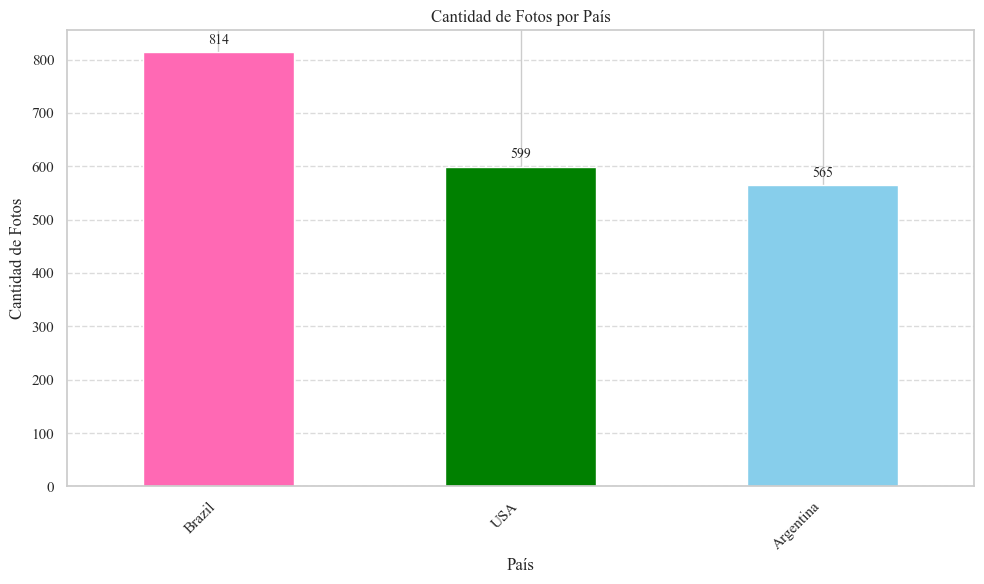

In [23]:

colores = {'Brazil': '#FF69B4', 'USA': 'green', 'Argentina': '#87CEEB'}

conteo_paises = nuevo_df2['country'].value_counts()

plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
ax = conteo_paises.plot(kind='bar', color=[colores.get(x, '#skyblue') for x in conteo_paises.index])

for i, v in enumerate(conteo_paises):
    ax.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)

plt.title('Cantidad de Fotos por País')
plt.xlabel('País')
plt.ylabel('Cantidad de Fotos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


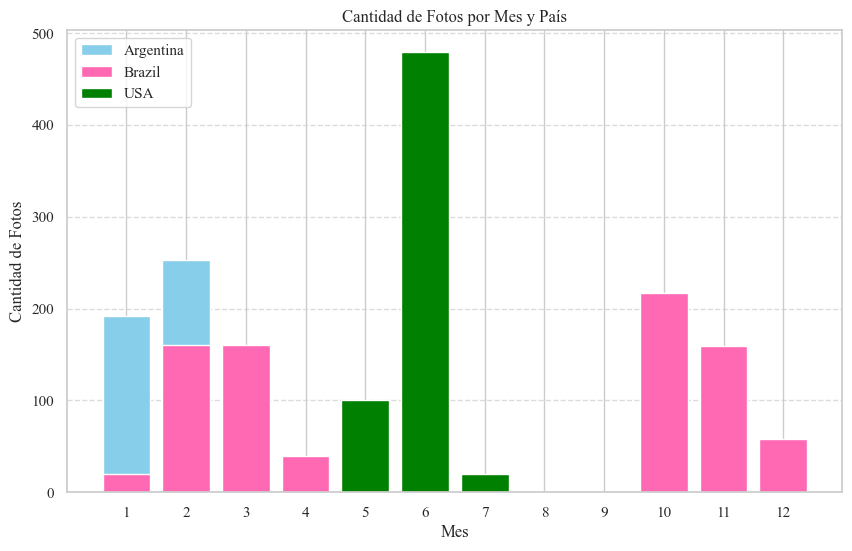

In [24]:

colores = {'Brazil': '#FF69B4', 'USA': 'green', 'Argentina': '#87CEEB'}

monthly_counts = tabla_vuelos.groupby(['month', 'country'])['count'].sum().unstack()

plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
for country in monthly_counts.columns:
    plt.bar(monthly_counts.index, monthly_counts[country], color=colores[country], label=country)

plt.xlabel('Mes')
plt.ylabel('Cantidad de Fotos')
plt.title('Cantidad de Fotos por Mes y País')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Horario por país

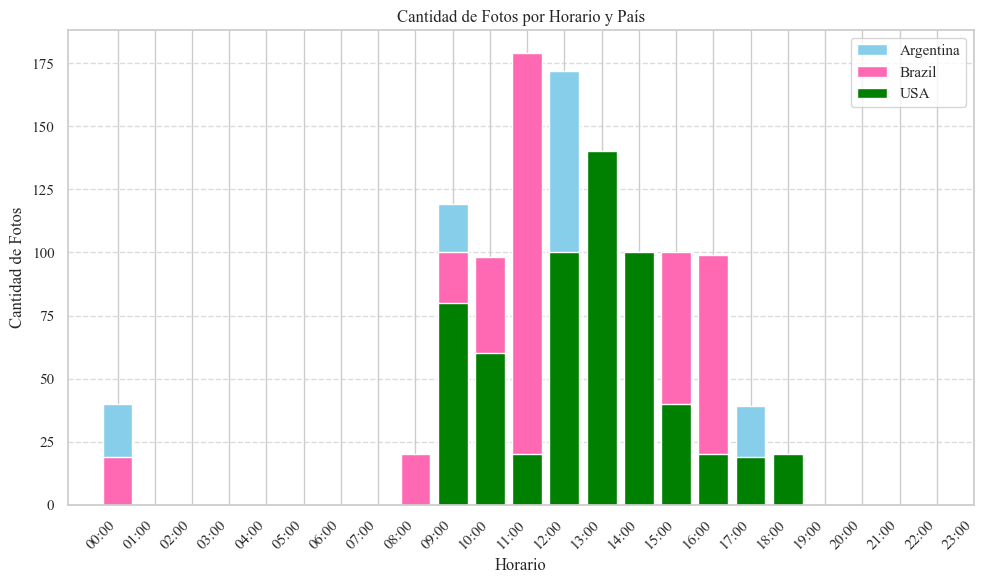

In [25]:
nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])

nuevo_df2['year'] = nuevo_df2['flight_date'].dt.year
nuevo_df2['month'] = nuevo_df2['flight_date'].dt.month
nuevo_df2['hour'] = nuevo_df2['flight_date'].dt.hour

paises_unicos = nuevo_df2['country'].unique()

tabla_vuelos = pd.DataFrame()

for pais in paises_unicos:
    df_pais = nuevo_df2[nuevo_df2['country'] == pais]
    vuelos_por_hora = df_pais.groupby(['year', 'month', 'hour']).size().reset_index(name='count')
    vuelos_por_hora['country'] = pais
    tabla_vuelos = pd.concat([tabla_vuelos, vuelos_por_hora])

tabla_vuelos = tabla_vuelos[['country', 'year', 'month', 'hour', 'count']]

hourly_counts = tabla_vuelos.groupby(['hour', 'country'])['count'].sum().unstack()

plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
for country in hourly_counts.columns:
    plt.bar(hourly_counts.index, hourly_counts[country], color=colores[country], label=country)

plt.xlabel('Horario')
plt.ylabel('Cantidad de Fotos')
plt.title('Cantidad de Fotos por Horario y País')
plt.xticks(range(24), [f'{hour:02d}:00' for hour in range(24)], rotation=45, ha='right')  # Formato hh:mm
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  
plt.show()



## Etiquetado por país

In [13]:
total_registros_por_pais = nuevo_df2.groupby('country').size()
proporcion_tags_por_pais = pd.DataFrame(columns=['País'])
proporcion_tags_por_pais['País'] = total_registros_por_pais.index
tags_columns = ['dark_soil', 'red_soil', 'high_plant_density', 'shadow', 'stubble', 'weed', 'blurry', 'dark_image', 'bright_image', 'grown_plants', 'double_plants']

for tag in tags_columns:
    total_registros_con_tag_por_pais = nuevo_df2.groupby('country')[tag].sum()
    proporcion = total_registros_con_tag_por_pais / total_registros_por_pais
    proporcion_tags_por_pais[tag] = proporcion.values

print(proporcion_tags_por_pais)

        País  dark_soil  red_soil  high_plant_density    shadow   stubble  \
0  Argentina   0.732743  0.033628            0.141593  0.798230  0.623009   
1     Brazil   0.656020  1.000000            0.171990  0.584767  0.975430   
2        USA   0.801336  0.100167            0.499165  0.565943  0.599332   

       weed    blurry  dark_image  bright_image  grown_plants  double_plants  
0  0.366372  0.207080    0.060177      0.106195      0.247788       0.555752  
1  0.558968  0.266585    0.318182      0.073710      0.147420       0.557740  
2  0.267112  0.133556    0.033389      0.133556      0.400668       0.333890  


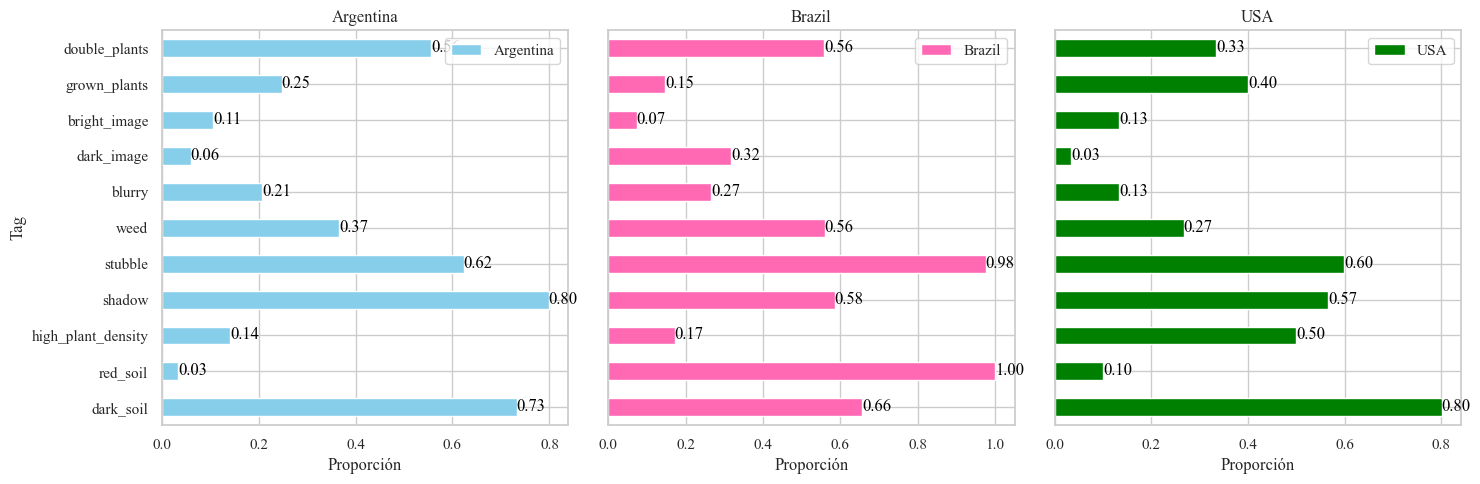

In [26]:
colores = {'Brazil': '#FF69B4', 'USA': 'green', 'Argentina': '#87CEEB'}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
plt.rcParams['font.family'] = 'Times New Roman'
for ax, (_, proporcion) in zip(axes, proporcion_tags_por_pais.iterrows()):  
    pais = proporcion['País']  
    color = colores[pais]
    proporcion[1:].plot(kind='barh', ax=ax, color=color)
    ax.set_title(f'{pais}')  
    ax.set_xlabel('Proporción')
    ax.set_ylabel('Tag')
    ax.legend([f'{pais}'], loc='upper right')  
    for i, prop in enumerate(proporcion[1:]):
        ax.text(prop, i, f'{prop:.2f}', ha='left', va='center', color='black')

plt.tight_layout()  
plt.show() 





## Frecuencia de etiquetas

Se han guardado 113 casos coincidentes en 'layoutsWithTags_coincidentes.csv'.


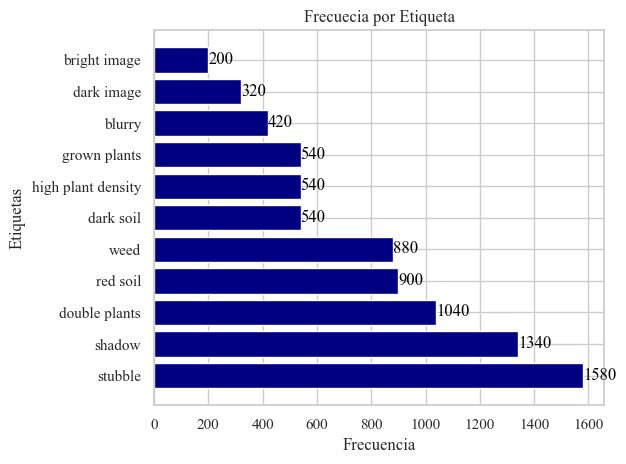

In [27]:

# Conteo de fotos por conjunto
fotos_por_set = defaultdict(int)

directorio = './clean_images'

for filename in os.listdir(directorio):
    if filename.endswith('.png'):
        numero_set = filename.split('_')[0]
        fotos_por_set[numero_set] += 1

# Lectura del archivo CSV
df = pd.read_csv('layoutsWithTags.csv')
numeros_de_sets_csv = df['layout_id'].unique()

# Verificación de coincidencia entre los conjuntos del CSV y los archivos de imágenes
def verificar_coincidencia(numero_set_csv):
    return str(numero_set_csv) in fotos_por_set

df['coincidencia'] = df['layout_id'].apply(verificar_coincidencia)
df_coincidentes = df[df['coincidencia']]

# Guardar casos coincidentes en un nuevo archivo CSV
df_coincidentes.to_csv('layoutsWithTags_coincidentes.csv', index=False)

print(f"Se han guardado {len(df_coincidentes)} casos coincidentes en 'layoutsWithTags_coincidentes.csv'.")

# Mapeo de etiquetas
etiquetas_claves = {
    'dark soil': 1,
    'red soil': 2,
    'high plant density': 3,
    'shadow': 4,
    'stubble': 5,
    'weed': 6,
    'blurry': 7,
    'dark image': 8,
    'bright image': 9,
    'grown plants': 10,
    'double plants': 11
}

# Extracción y conteo de etiquetas
numeros = df['relevant (new) tags'].str.split(',')
todos_los_numeros = []

for sublist in numeros.dropna():
    for numero in sublist:
        if numero.strip():  # Ignorar valores vacíos
            todos_los_numeros.append(int(numero))

conteo_numeros = pd.Series(todos_los_numeros).value_counts()
conteo_numeros = conteo_numeros.sort_values(ascending=False)
etiquetas = [list(etiquetas_claves.keys())[list(etiquetas_claves.values()).index(num)] for num in conteo_numeros.index]

# Gráfico de barras con ejes invertidos y etiquetas
plt.rcParams['font.family'] = 'Times New Roman'
plt.barh(etiquetas, (conteo_numeros.values*20), color='navy')
plt.ylabel('Etiquetas')
plt.xlabel('Frecuencia')
plt.title('Frecuecia por Etiqueta')

# Agregar etiquetas en cada barra
for i, v in enumerate(conteo_numeros.values*20):
    plt.text(v, i, str(v), color='black', ha='left', va='center')

plt.tight_layout()
plt.show()





## Muestra de fotos por país

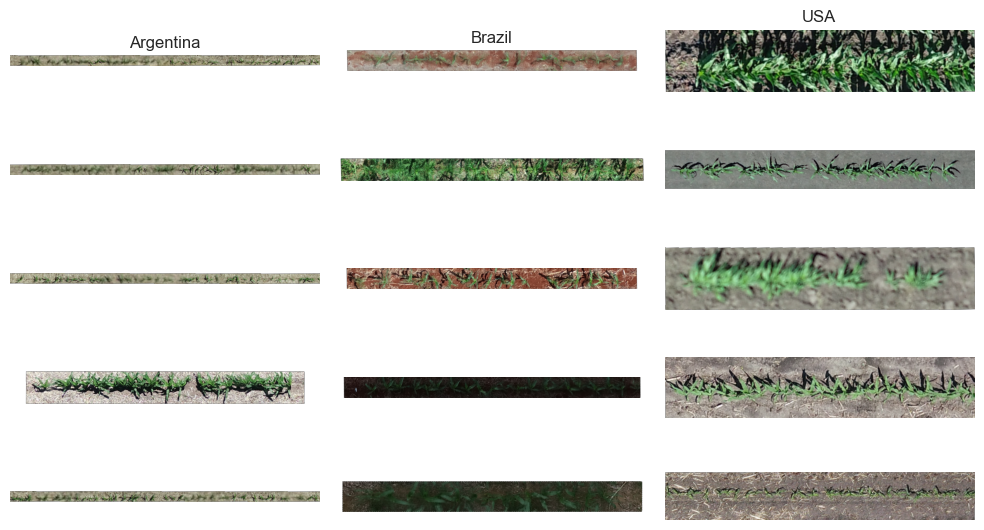

In [16]:

def mostrar_muestra_aleatoria_por_pais_tabla(df, directorio, num_muestras=5, umbral_ancho=1500):
    df_imagenes = pd.DataFrame(columns=df['country'].unique())
    
    for pais in df_imagenes.columns:
        df_pais = df[df['country'] == pais]
        imagenes_menores_umbral = df_pais[df_pais['ancho'] < umbral_ancho]['nombre_imagen'].tolist()
        if len(imagenes_menores_umbral) < num_muestras:
            muestra = imagenes_menores_umbral
        else:
           muestra = random.sample(imagenes_menores_umbral, num_muestras)
        df_imagenes[pais] = muestra
    fig, axes = plt.subplots(num_muestras, len(df_imagenes.columns), figsize=(10, 6))
    
    if num_muestras == 1: 
        axes = axes.reshape((1, -1)) 
    
    for i, pais in enumerate(df_imagenes.columns):
        axes[0, i].set_title(pais)
        for j, imagen_nombre in enumerate(df_imagenes[pais]):
            ruta_imagen = os.path.join(directorio, imagen_nombre)            
            imagen = Image.open(ruta_imagen)
            if num_muestras > 1:
                ax = axes[j, i]
            else:
                ax = axes[i]  
            ax.imshow(imagen)
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    return df_imagenes

directorio_imagenes = './clean_images'

fotos = mostrar_muestra_aleatoria_por_pais_tabla(nuevo_df2, directorio_imagenes)
